In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw 


from PIL import Image, ExifTags
from matplotlib import cm

import h5py
from IPython.display import display

import torch 
from torch.utils.data import TensorDataset, DataLoader

from datasets import load_dataset
import datasets 
from datasets import Dataset

from transformers import ViTImageProcessor

(300, 300, 3)
<class 'list'>


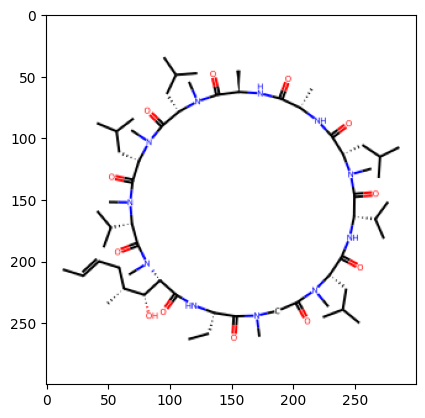

<PIL.Image.Image image mode=RGB size=300x300 at 0x16B989640> (7334,)


In [2]:
# Load the data from the h5py file
h5file = '../../../docs/data/PepNet_data.h5'

with h5py.File(h5file, 'r') as F:
    #print(type(F['images'][0]))
    images = np.array(F['images'])
    images = np.clip(images, 0, 255).astype(np.uint8)
    print(images[0].shape)
    #images = [Image.fromarray(img, 'RGB') for img in images]
    images = [Image.fromarray(img) for img in images]
    #images = [Image.fromarray((img * 255).astype(np.uint8) for img in images)]
    print(type(images))
    
    labels = np.array(F['permeability'])

#Verify the data
plt.imshow(images[0])
plt.show()

#print(images[0])
#print(labels[0])

data = images 

# we change the data type and permute the color channel axis from place 3 to 1, to conform with pytorch defaults.
#data = data.type(torch.float32).permute(0,3,1,2)  # leave this as is
# labels = labels.astype(torch.LongTensor)            # leave this as is
print(data[0], labels.shape)

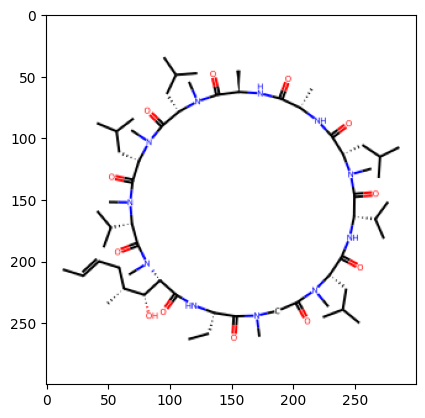

In [3]:
#Check if we can recontruct the image
img_array = np.array(images[0])
plt.imshow(img_array)

In [4]:
# Split sizes
#train_size = 5000
#val_size = 1334
#test_size = 1000

train_size = 10
val_size = 5
test_size = 10

# Randomly shuffle the data
np.random.shuffle(data)

# Split the data
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:train_size+val_size+test_size]

train_labels = labels[:train_size]
val_labels = labels[train_size:train_size+val_size]
test_labels = labels[train_size+val_size:train_size+val_size+test_size]

train_dict = {"img": train_data, "label": train_labels}
val_dict = {"img": val_data, "label": val_labels}
test_dict = {"img": test_data, "label": test_labels}

train_dataset = datasets.Dataset.from_dict(train_dict)#.cast_column("img", Image())
val_dataset = datasets.Dataset.from_dict(val_dict)#.cast_column("img", Image())
test_dataset = datasets.Dataset.from_dict(test_dict)#.cast_column("img", Image())

print(type(train_dataset), type(val_dataset), type(test_dataset))


<class 'datasets.arrow_dataset.Dataset'> <class 'datasets.arrow_dataset.Dataset'> <class 'datasets.arrow_dataset.Dataset'>


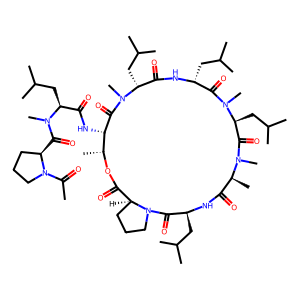

In [5]:
train_dataset[0]['img']


In [6]:
train_dataset[0]['label']

-6.6

####################################### Preprocessing the Data #######################################

In [7]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

/Users/ziadelmalki/anaconda3/envs/pepnet/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [9]:
train_dataset.set_transform(train_transforms)
val_dataset.set_transform(val_transforms)
test_dataset.set_transform(val_transforms)

In [10]:
train_dataset[:2]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=300x300>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=300x300>],
 'label': [-6.6, -6.2],
 'pixel_values': [tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9843, 0.7333],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
  
          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9843, 0.7333],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000,

In [12]:
train_dataset.shape

(10, 2)

In [13]:

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4)

In [14]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


#################################### Define the Model    ##############################################

In [25]:
from transformers import ViTForImageClassification
import torch.nn as nn

# Define your regression model based on ViT
class ViTForRegression(ViTForImageClassification):
    def __init__(self, config):
        super().__init__(config)
        # Modify the output layer for regression
        self.classifier = nn.Linear(config.hidden_size, 1)  # Output a single value


model = ViTForRegression.from_pretrained('google/vit-base-patch16-224-in21k',num_labels=1) #num_labels=1 to solve the target dimension mismatch with the input

Some weights of ViTForRegression were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
from transformers import TrainingArguments, Trainer

metric_name = "mean_squared_error"

args = TrainingArguments(
    f"PepNet_Model",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [38]:
#Maybe crop the predictions and labels so that the accuracy is correct when we are within a certain range of the true value

from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    #predictions = np.argmax(predictions, axis=1)
    return dict(mean_squared_error=mean_squared_error(predictions, labels))
    #return dict(accuracy=accuracy_score(predictions, labels))



In [39]:

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

######################################## Train the Model ######################################

# Start tensorboard.
!load_ext tensorboard
!tensorboard --logdir logs/

In [40]:
trainer.train()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 37.85955810546875, 'eval_mean_squared_error': 37.85955810546875, 'eval_runtime': 0.2933, 'eval_samples_per_second': 17.05, 'eval_steps_per_second': 6.82, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 36.59768295288086, 'eval_mean_squared_error': 36.59768295288086, 'eval_runtime': 1.2836, 'eval_samples_per_second': 3.895, 'eval_steps_per_second': 1.558, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 35.970787048339844, 'eval_mean_squared_error': 35.970787048339844, 'eval_runtime': 10.6029, 'eval_samples_per_second': 0.472, 'eval_steps_per_second': 0.189, 'epoch': 3.0}
{'train_runtime': 59.223, 'train_samples_per_second': 0.507, 'train_steps_per_second': 0.051, 'train_loss': 42.18249257405599, 'epoch': 3.0}


TrainOutput(global_step=3, training_loss=42.18249257405599, metrics={'train_runtime': 59.223, 'train_samples_per_second': 0.507, 'train_steps_per_second': 0.051, 'total_flos': 2324738852352000.0, 'train_loss': 42.18249257405599, 'epoch': 3.0})

###################################### Evaluate the Model ################################################

In [44]:
outputs = trainer.predict(test_dataset)
#print(outputs)

  0%|          | 0/3 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[-0.7783114 ],
       [-0.73980653],
       [-0.67001116],
       [-0.78567874],
       [-0.83510345],
       [-0.77071923],
       [-0.81386364],
       [-0.79857266],
       [-0.7809061 ],
       [-0.772426  ]], dtype=float32), label_ids=array([-6.68, -7.29, -6.75, -6.95, -7.12, -6.41, -6.3 , -5.31, -5.39,
       -5.46], dtype=float32), metrics={'test_loss': 31.766925811767578, 'test_mean_squared_error': 31.766925811767578, 'test_runtime': 9.9511, 'test_samples_per_second': 1.005, 'test_steps_per_second': 0.301})


In [42]:
print(outputs.metrics)

{'test_loss': 31.766925811767578, 'test_mean_squared_error': 31.766925811767578, 'test_runtime': 4.3271, 'test_samples_per_second': 2.311, 'test_steps_per_second': 0.693}
